<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/ocp_load_pretrained_and_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing OCP pretrained models
written by S.Choung 10th Oct
This codebase was initially built on the basis of https://pages.nist.gov/jarvis_leaderboard/ and https://open-catalyst-project.github.io/tutorial/fine-tuning/fine-tuning-oxides.html

## OCP installation

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

if not os.path.exists('ocp'):
     !git clone https://github.com/Open-Catalyst-Project/ocp.git
os.chdir('ocp')
!pip install -e .
!pip -q install  lmdb pymatgen==2023.5.10 ase==3.22.1 orjson e3nn==0.2.6 wandb
!pip install submitit

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ocp'...
remote: Enumerating objects: 11480, done.
remote: Counting objects: 100% (3705/3705), done.
remote: Compressing objects: 100% (1414/1414), done.
remote: Total 11480 (delta 2554), reused 3253 (delta 2253), pack-reused 7775
Receiving objects: 100% (11480/11480), 103.63 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (7819/7819), done.
Obtaining file:///content/ocp/ocp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ocp-models (pyproject.toml) ... done
  Created wheel for ocp-models: filename=ocp_models-0.0.3-0.editable-py3-none-any.whl size=3474 sha256=bad618240f41446dfa7cb1f13af8e2ff71b5f4dd4c5f37906921c9ebd08d8dd0
  Stored in directory: /t

In [ ]:
torch.cuda.is_available()

True

In [ ]:
import json,zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

from ase.io import read

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from ocpmodels.datasets import SinglePointLmdbDataset
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.models import CGCNN,SchNet
from ocpmodels.datasets import data_list_collater
from ocpmodels.common.relaxation.ase_utils import OCPCalculator


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")


## load some useful utillities
 code taken from https://open-catalyst-project.github.io/tutorial/fine-tuning/fine-tuning-oxides.html

In [ ]:
os.chdir('/content/ocp')
!wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt
!wget https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/is2re/schnet_all.pt
checkpoint_path = "/content/ocp/gemnet_t_direct_h512_all.pt"
config_yml_path = "configs/s2ef/all/gemnet/gemnet-dT.yml"

# Define the calculator
calc = OCPCalculator(config_yml=config_yml_path, checkpoint_path=checkpoint_path)

--2023-10-08 07:34:44--  https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/is2re/schnet_all.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.250.75, 13.224.250.44, 13.224.250.114, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.250.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14643781 (14M) [binary/octet-stream]
Saving to: ‘schnet_all.pt.1’

schnet_all.pt.1     100%[===================>]  13.96M  --.-KB/s    in 0.1s    

2023-10-08 07:34:45 (139 MB/s) - ‘schnet_all.pt.1’ saved [14643781/14643781]



In [ ]:
# @title
import ocpmodels as om
from pathlib import Path

def ocp_root():
    """Return the root directory of the installed ocp package."""
    return Path(om.__file__).parent.parent

def ocp_main():
    """Return the path to ocp main.py"""
    return ocp_root() / "main.py"

In [ ]:
# @title
import subprocess
import sys
import numba
import numpy as np
import ase
import e3nn
import pymatgen.core as pc
import torch
import torch.cuda as tc
import torch_geometric as tg
import platform
import psutil

def describe_ocp():
    """Print some system information that could be useful in debugging."""
    print(sys.executable, sys.version)
    print(f'ocp is installed at {ocp_root()}')

    commit_hash = (
            subprocess.check_output(
                    [
                        "git",
                        "-C",
                        om.__path__[0],
                        "describe",
                        "--always",
                    ]
                )
                .strip()
                .decode("ascii")
            )
    print(f'ocp repo is at git commit: {commit_hash}')
    print(f'numba: {numba.__version__}')
    print(f'numpy: {np.version.version}')
    print(f'ase: {ase.__version__}')
    print(f'e3nn: {e3nn.__version__}')
    print(f'pymatgen: {pc.__version__}')
    print(f'torch: {torch.version.__version__}')
    print(f'torch.version.cuda: {torch.version.cuda}')
    print(f'torch.cuda: is_available: {tc.is_available()}')
    if tc.is_available():
        print('  __CUDNN VERSION:', torch.backends.cudnn.version())
        print('  __Number CUDA Devices:', torch.cuda.device_count())
        print('  __CUDA Device Name:',torch.cuda.get_device_name(0))
        print('  __CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
    print(f'torch geometric: {tg.__version__}')
    print()
    print(f'Platform: {platform.platform()}')
    print(f'  Processor: {platform.processor()}')
    print(f'  Virtual memory: {psutil.virtual_memory()}')
    print(f'  Swap memory: {psutil.swap_memory()}')
    print(f'  Disk usage: {psutil.disk_usage("/")}')

In [ ]:
# @title
import urllib
import os
from pathlib import Path
import requests

checkpoints = {
    # Open Catalyst 2020 (OC20)
    'CGCNN 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_200k.pt',
    'CGCNN 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_2M.pt',
    'CGCNN 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_20M.pt',
    'CGCNN All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_all.pt',
    'DimeNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_200k.pt',
    'DimeNet 2M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_2M.pt',
    'SchNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_200k.pt',
    'SchNet 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_2M.pt',
    'SchNet 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_20M.pt',
    'SchNet All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_all_large.pt',
    'DimeNet++ 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_200k.pt',
    'DimeNet++ 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_2M.pt',
    'DimeNet++ 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_20M.pt',
    'DimeNet++ All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_all.pt',
    'SpinConv 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/spinconv_force_centric_2M.pt',
    'SpinConv All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/spinconv_force_centric_all.pt',
    'GemNet-dT 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/gemnet_t_direct_h512_2M.pt',
    'GemNet-dT All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt',
    'PaiNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_05/s2ef/painn_h512_s2ef_all.pt',
    'GemNet-OC 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_2M.pt',
    'GemNet-OC All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_all.pt',
    'GemNet-OC All+MD'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt',
    'GemNet-OC-Large All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_large_s2ef_all_md.pt',
    'SCN 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t1_b1_s2ef_2M.pt',
    'SCN-t4-b2 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t4_b2_s2ef_2M.pt',
    'SCN All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_all_md_s2ef.pt',
    'eSCN-L4-M2-Lay12 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l4_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_all_md_s2ef.pt',
    'eSCN-L6-M3-Lay20 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt',
    'EquiformerV2 (83M) 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_83M_2M.pt',
    'EquiformerV2 (31M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_31M_ec4_allmd.pt',
    'EquiformerV2 (153M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_153M_ec4_allmd.pt',
    # Open Catalyst 2022 (OC22)
    'GemNet-dT OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gndt_oc22_all_s2ef.pt',
    'GemNet-OC OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt',
    'GemNet-OC OC20+OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_05/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC OC20->OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_finetune_all_s2ef.pt'
                }

def list_checkpoints():
    """List checkpoints that are available to download."""
    print('See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.')
    for key in checkpoints:
        print(key)
    print('Copy one of these keys to get_checkpoint(key) to download it.')


def get_checkpoint(key):
    """Download a checkpoint.

    key: string in checkpoints.

    Returns name of checkpoint that was saved.
    """
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception('No url found for {key}')

    pt = Path(urllib.parse.urlparse(url).path).name

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt

In [ ]:
# @title
from pathlib import Path
import numpy as np
from ase.db import connect

def train_test_val_split(ase_db, ttv=(0.8, 0.1, .1), files=('train.db', 'test.db', 'val.db'), seed=42):
    """Split an ase db into train, test and validation dbs.

    ase_db: path to an ase db containing all the data.
    ttv: a tuple containing the fraction of train, test and val data. This will be normalized.
    files: a tuple of filenames to write the splits into. An exception is raised if these exist.
           You should delete them first.
    seed: an integer for the random number generator seed

    Returns the absolute path to files.
    """

    for db in files:
        if os.path.exists(db):
            raise Exception('{db} exists. Please delete it before proceeding.')

    src = connect(ase_db)
    N = src.count()

    ttv = np.array(ttv)
    ttv /= ttv.sum()

    train_end = int(N * ttv[0])
    test_end = train_end + int(N * ttv[1])

    train = connect(files[0])
    test = connect(files[1])
    val = connect(files[2])

    ids = np.arange(1, N + 1)
    rng = np.random.default_rng(seed=42)
    rng.shuffle(ids)

    for _id in ids[0:train_end]:
        row = src.get(id=int(_id))
        train.write(row.toatoms())

    for _id in ids[train_end:test_end]:
        row = src.get(id=int(_id))
        test.write(row.toatoms())

    for _id in ids[test_end:]:
        row = src.get(id=int(_id))
        val.write(row.toatoms())

    return [Path(f).absolute() for f in files]

In [ ]:
# @title
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper
import torch
import os
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
from io import StringIO
import sys
import contextlib

def generate_yml_config(checkpoint_path, yml='run.yml', delete=(), update=()):
    """Generate a yml config file from an existing checkpoint file.

    checkpoint_path: string to path of an existing checkpoint
    yml: name of file to write to.
    pop: list of keys to remove from the config
    update: dictionary of key:values to update

    Use a dot notation in update.

    Returns an absolute path to the generated yml file.
    """

    # You can't just read in the checkpoint with torch. The calculator does some things to it.
    # Rather than recreate that here I just reuse the calculator machinery. I don't want to
    # see the output though, so I capture it.

    with contextlib.redirect_stdout(StringIO()) as _:
        config = OCPCalculator(checkpoint_path=checkpoint_path).config # there seems an parameter checkpoint changed in OCPcalculator (s.choung)

    for key in delete:
        if key in config and len(key.split('.')) == 1:
            del config[key]
        else:
            keys = key.split('.')
            if keys[0] in config:
                d = config[keys[0]]
            else:
                continue
            if isinstance(d, dict):
                for k in keys[1:]:
                    if isinstance(d[k], dict):
                        d = d[k]
                    else:
                        if k in d:
                            del d[k]

    def nested_set(dic, keys, value):
        for key in keys[:-1]:
            dic = dic.setdefault(key, {})
        dic[keys[-1]] = value

    for _key in update:
        keys = _key.split('.')
        nested_set(config, keys, update[_key])


    out = dump(config)
    with open(yml, 'wb') as f:
        f.write(out.encode('utf-8'))

    return Path(yml).absolute()

## test run: O ads on Pt111 2x2 surface

In [ ]:
eSCN_checkpoint = get_checkpoint('eSCN-L6-M3-Lay20 All+MD')

In [ ]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint_path=os.path.expanduser(eSCN_checkpoint), cpu=False)

In [ ]:
from ase.build import fcc111, add_adsorbate
from ase.optimize import BFGS
from ase.constraints import FixAtoms

re1 = -3.03

slab = fcc111('Pt', size=(2, 2, 5), vacuum=10.0)
add_adsorbate(slab, 'O', height=1.2, position='fcc')

slab.set_calculator(calc)
opt = BFGS(slab)
opt.run(fmax=0.05, steps=100)
slab_e = slab.get_potential_energy()
slab_e + re1

for nlayers in [3, 4, 5, 6, 7, 8]:
    slab = fcc111('Pt', size=(2, 2, nlayers), vacuum=10.0)
    add_adsorbate(slab, 'O', height=1.2, position='fcc')

    slab.set_calculator(calc)
    opt = BFGS(slab, logfile=None)
    opt.run(fmax=0.2, steps=100)
    slab_e = slab.get_potential_energy()
    print(f'nlayers = {nlayers}: {slab_e + re1:1.2f} eV')
for size in [1, 2, 3, 4, 5]:
    slab = fcc111('Pt', size=(size, size, 5), vacuum=10.0)
    add_adsorbate(slab, 'O', height=1.2, position='fcc')

    slab.set_constraint(FixAtoms(mask=[atom.tag > 1 for atom in slab]))

    slab.set_calculator(calc)
    opt = BFGS(slab, logfile=None)
    opt.run(fmax=0.2, steps=100)
    slab_e = slab.get_potential_energy()
    print(f'({size}x{size}): {slab_e + re1:1.2f} eV')

      Step     Time          Energy         fmax
BFGS:    0 07:34:51        1.743818        1.6825
BFGS:    1 07:34:51        1.516008        0.9662
BFGS:    2 07:34:52        1.352490        0.7183
BFGS:    3 07:34:52        1.225733        0.7989
BFGS:    4 07:34:52        0.854934        0.6957
BFGS:    5 07:34:53        0.802092        0.4926
BFGS:    6 07:34:53        0.778268        0.6056
BFGS:    7 07:34:53        0.764442        0.7336
BFGS:    8 07:34:54        0.757019        0.5112
BFGS:    9 07:34:54        0.732688        0.1167
BFGS:   10 07:34:54        0.729960        0.0395
nlayers = 3: -2.40 eV
nlayers = 4: -2.29 eV
nlayers = 5: -2.30 eV
nlayers = 6: -2.28 eV
nlayers = 7: -2.28 eV
nlayers = 8: -2.30 eV
(1x1): -0.75 eV
(2x2): -2.16 eV
(3x3): -1.38 eV
(4x4): -1.30 eV
(5x5): -1.29 eV


## finetuning OCP pretrained model using oxide.db

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
if not os.path.exists('tutorial'):
     !git clone https://github.com/Open-Catalyst-Project/tutorial.git

In [ ]:
GemNet_checkpoint = get_checkpoint('GemNet-OC OC20+OC22')

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
with open('./tutorial/ocp-tutorial/fine-tuning/supporting-information.json', 'rb') as f:
     d = json.loads(f.read())
oxides = list(d.keys())
polymorphs = list(d['TiO2'].keys())
oxides, polymorphs

(['SnO2', 'IrO2', 'RuO2', 'TiO2', 'VO2'],
 ['rutile', 'pyrite', 'columbite', 'brookite', 'fluorite', 'anatase'])

In [ ]:
d

{'SnO2': {'rutile': {'PBE': {'EOS': {'calculations': [{'incar': {'doc': 'INCAR parameters',
        'prec': 'Normal',
        'isif': 4,
        'nbands': 20,
        'ibrion': 2,
        'gga': 'PE',
        'encut': 520.0,
        'ismear': 0,
        'sigma': 0.001,
        'nsw': 50},
       'doc': 'JSON representation of a VASP calculation.\n\nenergy is in eV\nforces are in eV/\\AA\nstress is in GPa (sxx, syy, szz,  syz, sxz, sxy)\nmagnetic moments are in Bohr-magneton\nThe density of states is reported with E_f at 0 eV.\nVolume is reported in \\AA^3\nCoordinates and cell parameters are reported in \\AA\n\nIf atom-projected dos are included they are in the form:\n{ados:{energy:data, {atom index: {orbital : dos}}}\n',
       'potcar': [['Sn',
         'potpaw/Sn/POTCAR',
         'b69d67e7e2a00643b5d75f462478dc99f0378474'],
        ['O', 'potpaw/O/POTCAR', '0cf2ce56049ca395c567026b700ed66c94a85161']],
       'input': {'kpts': [8, 8, 8],
        'reciprocal': False,
        'xc': 'L

In [ ]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint_path=GemNet_checkpoint, trainer='forces', cpu=False)

Elapsed time 27.7 seconds.


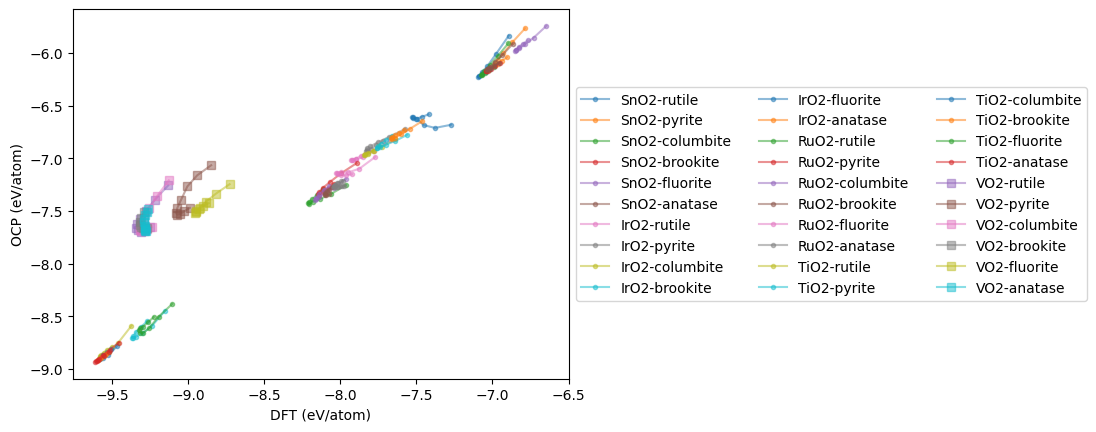

In [ ]:
import time
t0 = time.time()

eos_data = {}
for oxide in oxides:
    eos_data[oxide] = {}
    for polymorph in polymorphs:
        dft = []
        ocp = []
        vols = []
        calculations = d[oxide][polymorph]['PBE']['EOS']['calculations']
        for c in calculations:

            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))

            atoms.calc = calc
            ocp += [atoms.get_potential_energy() / len(atoms)]
            dft += [c['data']['total_energy'] / len(atoms)]
            vols += [atoms.get_volume()]
        plt.plot(dft, ocp, marker='s' if oxide == 'VO2' else '.',
                 alpha=0.5, label=f'{oxide}-{polymorph}')
        eos_data[oxide][polymorph] = (vols, dft, ocp)

plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);
print(f'Elapsed time {time.time() - t0:1.1f} seconds.')

In [ ]:
mae = np.mean(np.abs(np.array(dft) - np.array(ocp)))
print(f'MAE = {mae:1.3f} eV/atom')

MAE = 1.668 eV/atom


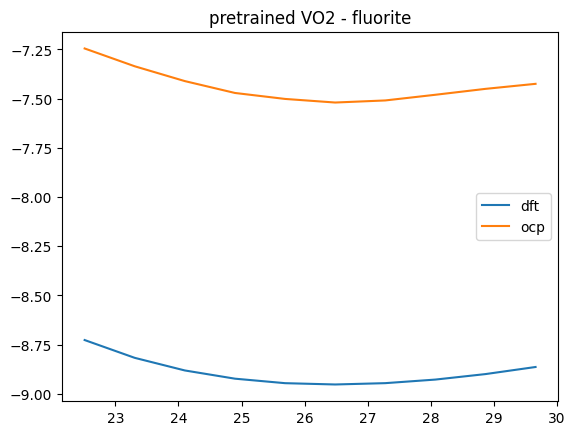

In [ ]:
oxide, polymorph = 'VO2', 'fluorite'
V, D, O = eos_data[oxide][polymorph]

plt.plot(V, D, label='dft')
plt.plot(V, O, label='ocp')
plt.title(f'pretrained {oxide} - {polymorph}')
plt.legend();

In [ ]:
from ase.db import connect
from ase.calculators.singlepoint import SinglePointCalculator

! rm -fr oxides.db  # start clean when you run this cell
db = connect('oxides.db')

In [ ]:
for oxide in oxides:
    for polymorph in polymorphs:
        for c in d[oxide][polymorph]['PBE']['EOS']['calculations']:
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            calc = SinglePointCalculator(atoms,
                                         energy=c['data']['total_energy'],
                                         forces=c['data']['forces'])
            atoms.set_calculator(calc)
            db.write(atoms)

In [ ]:
! rm -fr train.db test.db val.db

train, test, val = train_test_val_split('oxides.db')
train, test, val

(PosixPath('/content/ocp/train.db'),
 PosixPath('/content/ocp/test.db'),
 PosixPath('/content/ocp/val.db'))

In [ ]:
yml = generate_yml_config(GemNet_checkpoint, 'config.yml',
                   delete=['slurm', 'cmd', 'logger', 'task', 'model_attributes',
                           'optim.loss_force', # the checkpoint setting causes an error
                           'dataset', 'test_dataset', 'val_dataset'],
                   update={'gpus': 1,
                           'task.dataset': 'ase_db',
                           'optim.eval_every': 1,
                           'optim.max_epochs': 10,
                           # Train data
                           'dataset.train.src': 'train.db',
                           'dataset.train.a2g_args.r_energy': True,
                           'dataset.train.a2g_args.r_forces': True,
                            # Test data - prediction only so no regression
                           'dataset.test.src': 'test.db',
                           'dataset.test.a2g_args.r_energy': False,
                           'dataset.test.a2g_args.r_forces': False,
                           # val data
                           'dataset.val.src': 'val.db',
                           'dataset.val.a2g_args.r_energy': True,
                           'dataset.val.a2g_args.r_forces': True,
                          })
yml

PosixPath('/content/ocp/config.yml')

In [ ]:
!chmod +x /content/ocp/main.py


In [ ]:
import time

# Assuming ocp_main() returns a string representing the Python command
python_command = ocp_main()

t0 = time.time()
!python /content/ocp/main.py --mode train --config-yml $yml --checkpoint $GemNet_checkpoint --run-dir fine-tuning --identifier ft-oxides --amp > train.txt 2>&1

print(f'Elapsed time = {time.time() - t0:1.1f} seconds')


Elapsed time = 395.7 seconds


In [ ]:
cpline = !grep "checkpoint_dir:" train.txt
cpdir = cpline[0].split(':')[-1].strip()
cpdir

'fine-tuning/checkpoints/2023-10-08-07-42-56-ft-oxides'

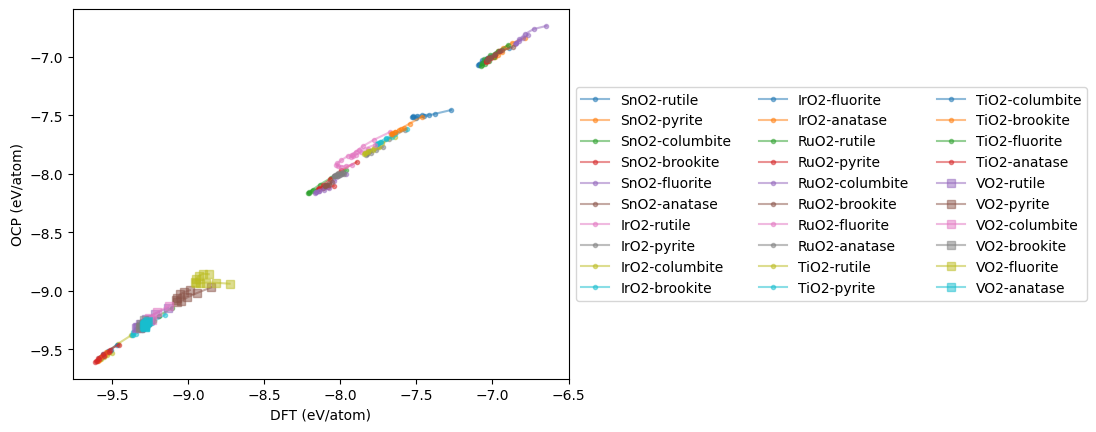

In [ ]:
newckpt = cpdir + '/checkpoint.pt'
newcalc = OCPCalculator(checkpoint_path=newckpt, cpu=False)
eos_data = {}
for oxide in oxides:
    eos_data[oxide] = {}
    for polymorph in polymorphs:
        dft = []
        ocp = []
        vols = []
        calculations = d[oxide][polymorph]['PBE']['EOS']['calculations']
        for c in calculations:

            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))

            atoms.calc = newcalc
            ocp += [atoms.get_potential_energy() / len(atoms)]
            dft += [c['data']['total_energy'] / len(atoms)]
            vols += [atoms.get_volume()]
        plt.plot(dft, ocp, marker='s' if oxide == 'VO2' else '.',
                 alpha=0.5, label=f'{oxide}-{polymorph}')
        eos_data[oxide][polymorph] = (vols, dft, ocp)

plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);

In [ ]:
mae = np.mean(np.abs(np.array(dft) - np.array(ocp)))
print(f'New MAE = {mae:1.3f} eV/atom')

New MAE = 0.010 eV/atom


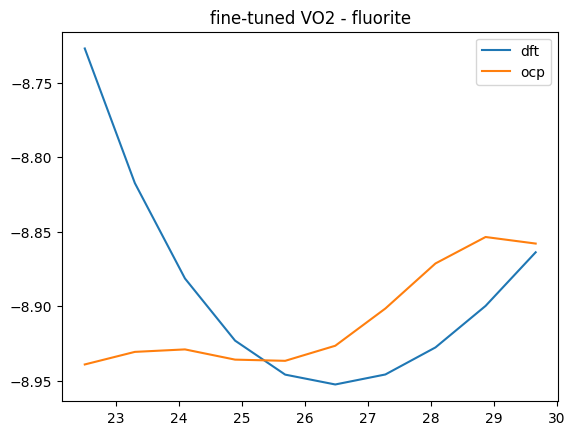

In [ ]:
oxide, polymorph = 'VO2', 'fluorite'
V, D, O = eos_data[oxide][polymorph]

plt.plot(V, D, label='dft')
plt.plot(V, O, label='ocp')
plt.title(f'fine-tuned {oxide} - {polymorph}')
plt.legend();

# Using Cathub data for finetunig